In [301]:
import os
import pandas as pd

def load_data_from_folders(folder_names, participant_file_prefix, ecg_file_name, eda_file_name):
    all_participants = []
    all_ecg = []
    all_eda = []

    for folder in folder_names:
        participant_files = [f for f in os.listdir(folder) if f.startswith(participant_file_prefix)]
        for file in participant_files:
            df_participant = pd.read_csv(os.path.join(folder, file))
            all_participants.append(df_participant)

        # Load ECG data
        ecg_file_path = os.path.join(folder, ecg_file_name)
        if os.path.exists(ecg_file_path):
            df_ecg = pd.read_csv(ecg_file_path)
            all_ecg.append(df_ecg)

        # Load EDA data
        eda_file_path = os.path.join(folder, eda_file_name)
        if os.path.exists(eda_file_path):
            df_eda = pd.read_csv(eda_file_path)
            all_eda.append(df_eda)

    # Concatenate all dataframes, ensuring consistent columns
    df_participants_combined = pd.concat(all_participants, ignore_index=True).reindex(columns=all_participants[0].columns)
    df_ecg_combined = pd.concat(all_ecg, ignore_index=True).reindex(columns=all_ecg[0].columns)
    df_eda_combined = pd.concat(all_eda, ignore_index=True).reindex(columns=all_eda[0].columns)

    return df_participants_combined, df_ecg_combined, df_eda_combined

folder_names = ['1', '2', '3', '4', '5', '6', '7']
participant_file_prefix = 'all_apps_wide'
ecg_file_name = 'ecg_results.csv'
eda_file_name = 'eda_results.csv'

df_participants_combined, df_ecg_combined, df_eda_combined = load_data_from_folders(folder_names, participant_file_prefix, ecg_file_name, eda_file_name)

participant_id = 'ae2kja5u'

# Remove rows where participant ID matches in df_participants_combined
df_participants_combined = df_participants_combined[df_participants_combined['participant.code'] != participant_id]

# Remove rows where participant ID matches in df_ecg_combined
df_ecg_combined = df_ecg_combined[df_ecg_combined['Participant'] != participant_id]

# Remove rows where participant ID matches in df_eda_combined
df_eda_combined = df_eda_combined[df_eda_combined['Participant'] != participant_id]

print(f'After removing rows for participant {participant_id}:')
print(f'Combined participant dataframe shape: {df_participants_combined.shape}')
print(f'Combined ECG dataframe shape: {df_ecg_combined.shape}')
print(f'Combined EDA dataframe shape: {df_eda_combined.shape}')

# Get unique participant IDs in each DataFrame
participant_ids_participants = set(df_participants_combined['participant.code'])
participant_ids_ecg = set(df_ecg_combined['Participant'])
participant_ids_eda = set(df_eda_combined['Participant'])

# Identify participant IDs present in participants but not in ECG or EDA
ids_in_participants_not_in_ecg = participant_ids_participants - participant_ids_ecg
ids_in_participants_not_in_eda = participant_ids_participants - participant_ids_eda

# Identify participant IDs present in ECG but not in participants
ids_in_ecg_not_in_participants = participant_ids_ecg - participant_ids_participants

# Identify participant IDs present in EDA but not in participants
ids_in_eda_not_in_participants = participant_ids_eda - participant_ids_participants

print(f'Participant IDs in participants but not in ECG: {ids_in_participants_not_in_ecg}')
print(f'Participant IDs in participants but not in EDA: {ids_in_participants_not_in_eda}')
print(f'Participant IDs in ECG but not in participants: {ids_in_ecg_not_in_participants}')
print(f'Participant IDs in EDA but not in participants: {ids_in_eda_not_in_participants}')

# Remove participants from df_participants_combined that are not in both ECG and EDA
valid_participant_ids = participant_ids_ecg.intersection(participant_ids_eda)
df_participants_combined = df_participants_combined[df_participants_combined['participant.code'].isin(valid_participant_ids)]

print(f'After removing participants not in both ECG and EDA:')
print(f'Combined participant dataframe shape: {df_participants_combined.shape}')
print(df_eda_combined.columns)


After removing rows for participant ae2kja5u:
Combined participant dataframe shape: (52, 1949)
Combined ECG dataframe shape: (276, 74)
Combined EDA dataframe shape: (276, 6)
Participant IDs in participants but not in ECG: {'pnvum9qr', 'enkeak0f', 'vrc5kdqt', '05qhlznq', '817n2sy5', 'wu7bftuk', 'pej4oig9', 'avanznds', 'xvr7iis7', 'wqzbi8s4', '1pvmqdfo', 'cmernh12', 'h7gbsrk6', '5h7twk6a', 'yu1cizf1'}
Participant IDs in participants but not in EDA: {'pnvum9qr', 'enkeak0f', 'vrc5kdqt', '05qhlznq', '817n2sy5', 'wu7bftuk', 'pej4oig9', 'avanznds', 'xvr7iis7', 'wqzbi8s4', '1pvmqdfo', 'cmernh12', 'h7gbsrk6', '5h7twk6a', 'yu1cizf1'}
Participant IDs in ECG but not in participants: set()
Participant IDs in EDA but not in participants: set()
After removing participants not in both ECG and EDA:
Combined participant dataframe shape: (37, 1949)
Index(['Session_Time', 'Participant', 'Group', 'Type', 'Phasic_Mean',
       'Tonic_Mean'],
      dtype='object')


In [302]:
df_eda_combined.drop(columns=['Session_Time'], inplace=True)

# Check the number of windows (unique Type values) before the merge
num_windows_ecg_before = df_ecg_combined['Type'].nunique()
num_windows_eda_before = df_eda_combined['Type'].nunique()
print(f'Number of windows in ECG data before merge: {num_windows_ecg_before}')
print(f'Number of windows in EDA data before merge: {num_windows_eda_before}')

# Merge the DataFrames on "Participant" and "Type"
df_combined = pd.merge(df_ecg_combined, df_eda_combined, on=['Participant', 'Type', 'Group'])

# Check the number of windows (unique Type values) after the merge
num_windows_combined_after = df_combined['Type'].nunique()
print(f'Number of windows in combined data after merge: {num_windows_combined_after}')

# Check if the number of windows is the same before and after the merge
if num_windows_ecg_before == num_windows_eda_before == num_windows_combined_after:
    print('The number of windows is consistent before and after the merge.')
else:
    print('The number of windows is not consistent before and after the merge.')


Number of windows in ECG data before merge: 11
Number of windows in EDA data before merge: 11
Number of windows in combined data after merge: 11
The number of windows is consistent before and after the merge.


In [303]:
df_combined[:12]

,Session,Participant,Group,Type,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,...,Comparison_HRV_LF,Comparison_HRV_HF,Comparison_HRV_VHF,Comparison_HRV_TP,Comparison_HRV_LFHF,Comparison_HRV_LFn,Comparison_HRV_HFn,Comparison_HRV_LnHF,Phasic_Mean,Tonic_Mean
0,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Baseline,686.789272,58.815860,19.767745,56.745324,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346684,14163.082771
1,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 1,634.191489,59.122096,40.292777,48.015389,NaN,NaN,...,-0.008354,-0.005529,-0.000091,-0.017311,0.006843,-0.008005,-0.006628,-0.542240,44.392272,35571.287094
2,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 2,687.142308,57.528362,4.237788,56.952355,NaN,NaN,...,0.014913,0.001541,0.001145,0.015720,0.852267,0.128675,-0.057001,0.110311,3.427230,26347.749053
3,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 3,698.925490,74.875844,37.703693,66.481564,NaN,NaN,...,-0.010098,-0.011518,-0.000571,-0.026843,4.382170,0.160723,-0.202674,-2.055056,-2.824480,23716.558192
4,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 4,675.686792,51.633653,24.669015,47.351427,NaN,NaN,...,0.019777,-0.004066,0.000082,0.017891,2.839087,0.187509,-0.158658,-0.367877,-0.185775,21683.653258
5,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 5,654.718978,49.726776,5.558034,49.180231,NaN,NaN,...,-0.002843,-0.005746,0.000262,-0.001968,0.789629,-0.047086,-0.126232,-0.570862,3.477194,28403.904392
6,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 6,703.568627,75.905571,26.734756,71.772906,NaN,NaN,...,0.024946,-0.007552,-0.000138,0.011974,6.439306,0.353428,-0.206118,-0.847982,0.017606,22402.571261
7,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 7,685.394636,58.498467,19.757508,55.747242,NaN,NaN,...,0.010135,-0.007256,0.000107,-0.000041,3.555733,0.238276,-0.169977,-0.797000,-3.277527,19115.760925
8,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 8,666.185874,58.639829,40.821315,48.229485,NaN,NaN,...,-0.010022,-0.007465,-0.000414,-0.018833,0.231181,-0.048442,-0.068524,-0.832616,-0.738274,17004.915164
9,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 9,647.728261,46.296775,17.827806,44.245424,NaN,NaN,...,0.014070,-0.001880,0.000389,0.012483,1.494298,0.148571,-0.104211,-0.153568,0.145462,21980.406851


### **Transform the features relative to baseline**

In [304]:
# Liste der relevanten Spalten (alle außer 'Session', 'Participant', 'Group' und 'Type')
relevant_columns = [col for col in df_combined.columns if col not in ['Session', 'Participant', 'Group', 'Type']]

# Neuer DataFrame für die Ergebnisse
df_combined_relative = df_combined.copy()

# Iteriere über die Teilnehmer
participants = df_combined['Participant'].unique()
for participant in participants:
    # Initialisierung der Baseline-Werte
    baseline_values = None
    
    # Iteriere über die Zeilen des Teilnehmers
    for idx, row in df_combined[df_combined['Participant'] == participant].iterrows():
        if row['Type'] == 'Baseline':
            # Aktualisiere die Baseline-Werte
            baseline_values = row[relevant_columns]
        else:
            if baseline_values is not None:
                # Berechne prozentuale Veränderung für die relevanten Spalten
                for col in relevant_columns:
                    baseline_value = baseline_values[col]
                    if pd.notna(baseline_value) and baseline_value != 0 and pd.notna(row[col]):
                        df_combined_relative.loc[idx, col] = ((row[col] - baseline_value) / baseline_value) * 100
                    else:
                        df_combined_relative.loc[idx, col] = row[col]

# Ergebnis anzeigen
df_combined_relative.head(20)

df_combined = df_combined_relative

In [173]:
df_combined.head()

,Session,Participant,Group,Type,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,...,Comparison_HRV_LF,Comparison_HRV_HF,Comparison_HRV_VHF,Comparison_HRV_TP,Comparison_HRV_LFHF,Comparison_HRV_LFn,Comparison_HRV_HFn,Comparison_HRV_LnHF,Phasic_Mean,Tonic_Mean
0,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Baseline,686.789272,58.815860,19.767745,56.745324,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346684,14163.082771
1,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 1,-7.658504,0.520669,103.830929,-15.384414,NaN,NaN,...,-0.008354,-0.005529,-0.000091,-0.017311,0.006843,-0.008005,-0.006628,-0.542240,12704.808329,151.154976
2,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 2,0.051404,-2.189032,-78.562106,0.364842,NaN,NaN,...,0.014913,0.001541,0.001145,0.015720,0.852267,0.128675,-0.057001,0.110311,888.573607,86.031173
3,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 3,1.767095,27.305533,90.733410,17.157783,NaN,NaN,...,-0.010098,-0.011518,-0.000571,-0.026843,4.382170,0.160723,-0.202674,-2.055056,-914.712055,67.453362
4,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 4,-1.616577,-12.211345,24.794281,-16.554487,NaN,NaN,...,0.019777,-0.004066,0.000082,0.017891,2.839087,0.187509,-0.158658,-0.367877,-153.586096,53.099813


### **Compute number of time windows**

In [305]:
# Initialize a dictionary to store the window counts for each participant
participant_window_counts = {}

# Iterate over the unique participants in the DataFrame
for participant_id in df_combined['Participant'].unique():
    # Filter the DataFrame for the current participant
    participant_data = df_combined[df_combined['Participant'] == participant_id]
    
    # Initialize a flag to track the first and second occurrences of "Baseline"
    first_baseline_found = False
    window_count = 0
    
    # Iterate over the rows in the participant's DataFrame
    for index, row in participant_data.iterrows():
        if row['Type'] == "Baseline":
            if not first_baseline_found:
                first_baseline_found = True
            else:
                break
        elif first_baseline_found:
            # Count the rows between the first and second "Baseline"
            window_count += 1
    
    # Store the window count for the current participant in the dictionary
    participant_window_counts[participant_id] = window_count

# Print the dictionary of participant window counts
print(participant_window_counts)


{'zzq192rp': 9, '4pzbw8ti': 10, 'pr8gga0e': 9, '3dvp3eki': 10, 's718hh4o': 7, 'd6trggw6': 7, 'fjbwsihs': 7, 'zgq44p8k': 7, 'zlye0d24': 7, '1qwm4iwc': 6, 'vy5eckgs': 6, 'nwml5w8o': 6, 'smtfk53l': 6, 'p1nxdrg9': 6, '8peubku6': 9, '9csokkab': 8, '0qmpak73': 8, 'vtvy5ljn': 9, 'yf8b4via': 8, 'mhgyqk79': 9, '8ca9ujvu': 4, '12jbb73p': 4, 'hlor9ppp': 4, '43kikdm9': 4, 'rojfnac5': 4, 'gwh4lqry': 4, 'hz5dvvyr': 5, 'uvcy2il3': 5, 'zjy1zx27': 5, '65l2486h': 5, 'yuczq5zy': 5, 't76jpd8d': 6, 'lyv3gwkg': 6, 'lfa1lork': 6, 'c7evkz8e': 6, 'n81us8iu': 6, 'h40ep8k0': 6}


# Reconstruct wallet history and profit/loss for each round


Durchschnittliche Aktienpreise der Runden 1-40:
15.54-17.2-17.06-18.23-18.43-20.24-21.17-23.27-25.0-26.64-28.12-30.43-28.26-28.56-29.24-28.53-25.95-24.5-23.79-21.87-20.05-18.8-18.07-16.77-14.07-15.7-14.99-15.25-15.08-15.53-14.99-15.06-14.99-15.06-14.72-14.21-13.88-13.96-13.79-14.2

Teilnehmer Preisverlauf:
14-15.54-17.2-17.06-18.23-18.43-20.24-21.17-23.27-25.0-26.64-28.12-30.43-28.26-28.56-29.24-28.53-25.95-24.5-23.79-21.87-20.05-18.8-18.07-16.77-14.07-15.7-14.99-15.25-15.08-15.53-14.99-15.06-14.99-15.06-14.72-14.21-13.88-13.96-13.79-14.2

Anzahl der Einträge im Preisverlauf:
41


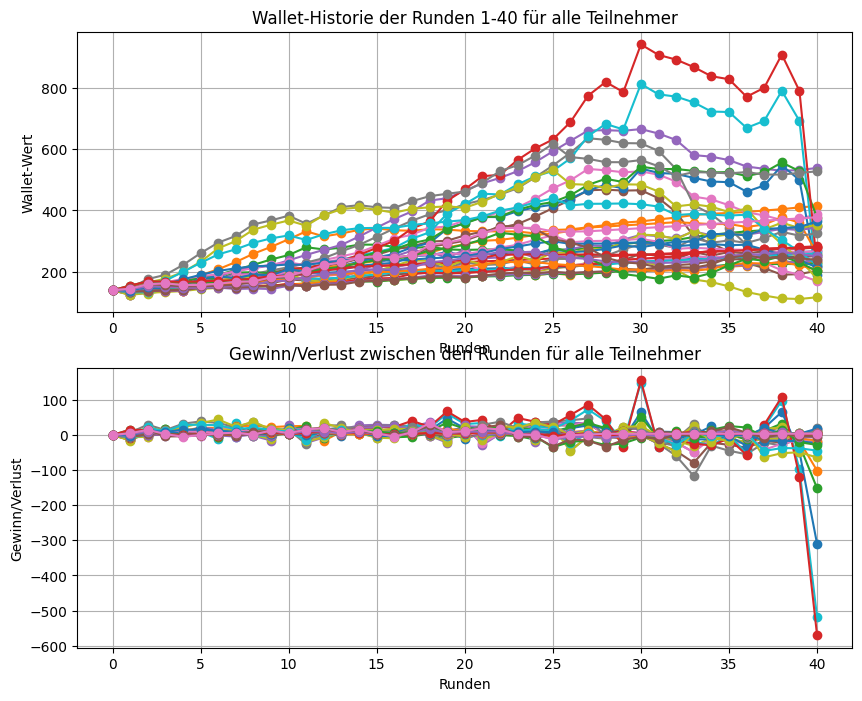

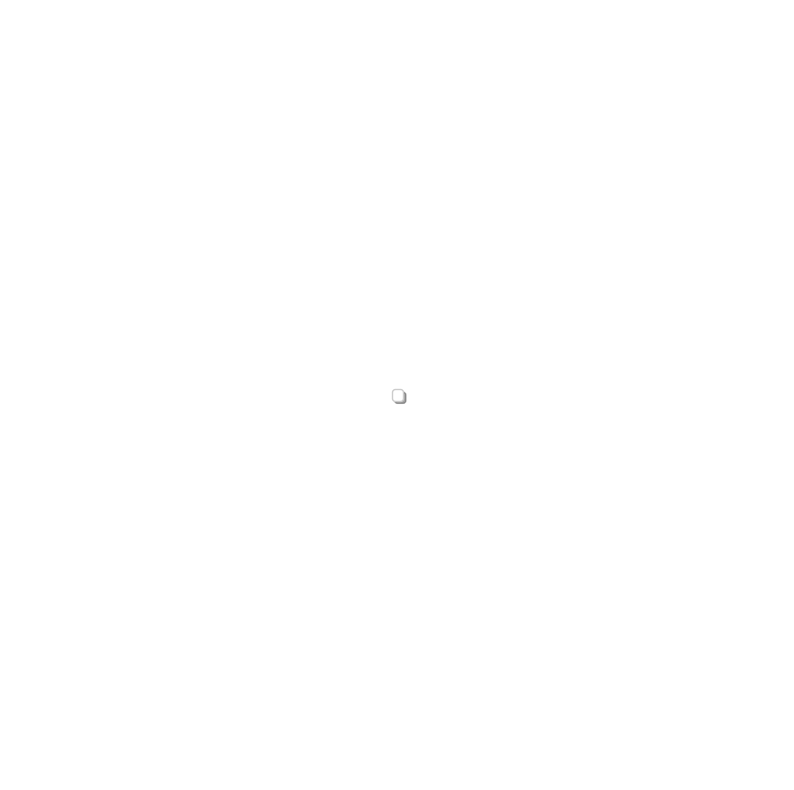

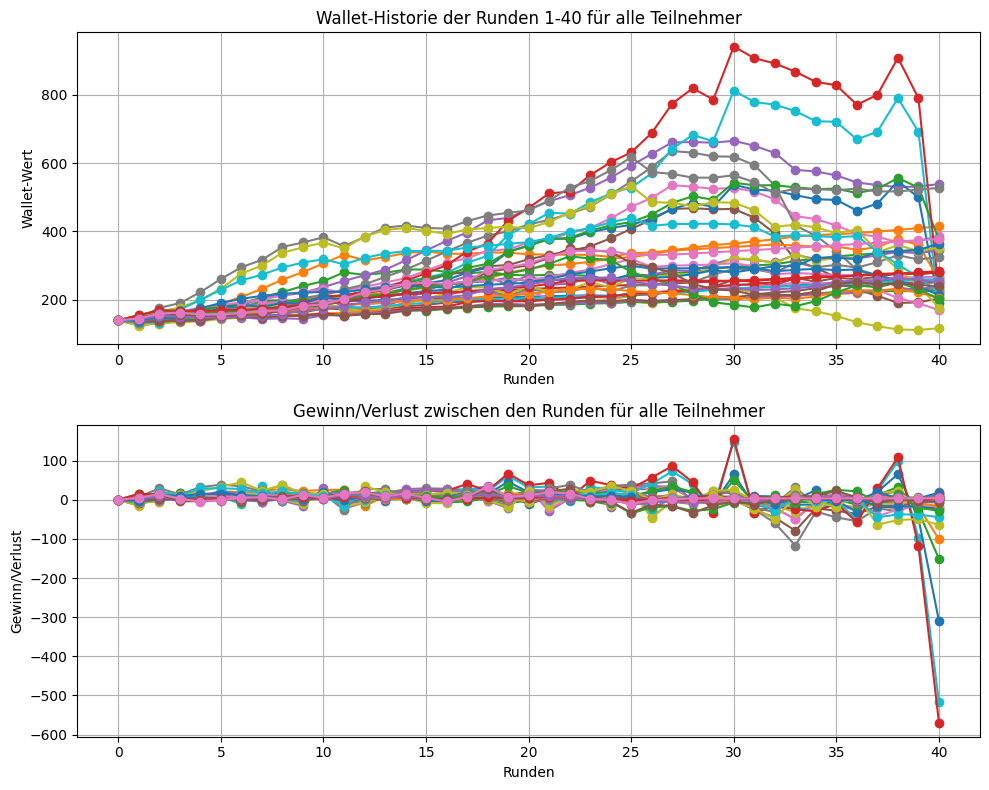


No discrepancies found between calculated final wallet and reported final score.


In [306]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# Assuming df_participants_combined is already loaded

# Extract and print the values for "stockmarket.x.player.avg_price" (x: 1-40)
avg_prices = [df_participants_combined[f'stockmarket.{i}.player.avg_price'].iloc[0] for i in range(1, 41)]
print("\nDurchschnittliche Aktienpreise der Runden 1-40:")
print("-".join(map(str, avg_prices)))

# Extract and print the values for "participant.price_history"
price_history = df_participants_combined['participant.price_history'].iloc[0]
price_history_values = price_history.strip('[]').split(', ')
print("\nTeilnehmer Preisverlauf:")
print("-".join(price_history_values))

# Print the number of entries in the "participant.price_history" list
print("\nAnzahl der Einträge im Preisverlauf:")
print(len(price_history_values))

# Calculate the wallet history, profit/loss, and assign start and end times for all participants
data = []
discrepancies = []

for index, row in df_participants_combined.iterrows():
    wallet_history = [140]  # Add the wallet value before round 1
    start_times = []
    end_times = []
    profit_loss_history = [0]  # Initialize profit/loss for the first round with 0
    for i in range(1, 41):
        cash = row[f'stockmarket.{i}.player.cash']
        dividend = row[f'stockmarket.{i}.player.dividend']
        interest = row[f'stockmarket.{i}.player.interest']
        stocks = row[f'stockmarket.{i}.player.stocks']
        next_avg_price = row[f'stockmarket.{i+1}.player.avg_price'] if i < 40 else None
        wallet = cash + dividend + interest + stocks * next_avg_price if next_avg_price is not None else row['stockmarket.40.player.final_score']
        wallet_history.append(wallet)
        start_time_col = f'stockmarket.{i}.player.d1_start'
        end_time_col = f'stockmarket.{i+1}.player.d1_start' if i < 40 else None
        start_time = datetime.fromtimestamp(row[start_time_col] / 1000.0).strftime('%Y-%m-%d %H:%M:%S') if pd.notna(row[start_time_col]) else None
        end_time = datetime.fromtimestamp(row[end_time_col] / 1000.0).strftime('%Y-%m-%d %H:%M:%S') if end_time_col is not None and pd.notna(row[end_time_col]) else None
        start_times.append(start_time)
        end_times.append(end_time)
        profit_loss = wallet_history[i] - wallet_history[i - 1]
        profit_loss_history.append(profit_loss)
    # Check if the calculated final wallet matches the reported final score
    calculated_final_wallet = wallet_history[-1]
    reported_final_score = row['stockmarket.40.player.final_score']
    if calculated_final_wallet != reported_final_score:
        discrepancies.append({
            'participant_id': row['participant.id_in_session'],
            'participant_code': row['participant.code'],
            'calculated_final_wallet': calculated_final_wallet,
            'reported_final_score': reported_final_score
        })
    data.append({'participant_id': row['participant.id_in_session'], 'participant_code': row['participant.code'], 'wallet_history': wallet_history, 'profit_loss_history': profit_loss_history, 'start_times': start_times, 'end_times': end_times})

plt.figure(figsize=(10, 8))

# Plot for wallet history
plt.subplot(2, 1, 1)
for item in data:
    player_id = item['participant_code']
    wallet_history = item['wallet_history']
    label = f'Spieler {player_id}'
    plt.plot(range(0, 41), wallet_history, marker='o', linestyle='-', label=label)
plt.xlabel('Runden')
plt.ylabel('Wallet-Wert')
plt.title('Wallet-Historie der Runden 1-40 für alle Teilnehmer')
plt.grid(True)

# Plot for profit/loss between rounds
plt.subplot(2, 1, 2)
for item in data:
    player_id = item['participant_code']
    profit_loss_history = item['profit_loss_history']
    plt.plot(range(0, 41), profit_loss_history, marker='o', linestyle='-', label=f'Spieler {player_id}')
plt.xlabel('Runden')
plt.ylabel('Gewinn/Verlust')
plt.title('Gewinn/Verlust zwischen den Runden für alle Teilnehmer')
plt.grid(True)

# Save the legend as a separate image
plt.figure(figsize=(10, 10))
plt.legend([f'Spieler {item["participant_code"]}' for item in data], loc='center', bbox_to_anchor=(0.5, 0.5), shadow=True, ncol=2)
plt.axis('off')
plt.savefig('legend.png', bbox_inches='tight')

# Show the main plots without legend
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for item in data:
    player_id = item['participant_code']
    wallet_history = item['wallet_history']
    plt.plot(range(0, 41), wallet_history, marker='o', linestyle='-')
plt.xlabel('Runden')
plt.ylabel('Wallet-Wert')
plt.title('Wallet-Historie der Runden 1-40 für alle Teilnehmer')
plt.grid(True)

plt.subplot(2, 1, 2)
for item in data:
    player_id = item['participant_code']
    profit_loss_history = item['profit_loss_history']
    plt.plot(range(0, 41), profit_loss_history, marker='o', linestyle='-')
plt.xlabel('Runden')
plt.ylabel('Gewinn/Verlust')
plt.title('Gewinn/Verlust zwischen den Runden für alle Teilnehmer')
plt.grid(True)

plt.tight_layout()
plt.savefig('plots_without_legend.png')
plt.show()


# Convert the data to a DataFrame
new_df = pd.DataFrame(data)

# Write the DataFrame to a CSV file
new_df.to_csv('wallet_history_with_timepoints.csv', index=False)

if discrepancies:
    print("\nDiscrepancies found between calculated final wallet and reported final score:")
    for discrepancy in discrepancies:
        print(discrepancy)
else:
    print("\nNo discrepancies found between calculated final wallet and reported final score.")


### **Checking entry lengths**

In [176]:
for entry in data:
    participant_id = entry['participant_code']
    profit_loss_history = entry['profit_loss_history']
    number_of_entries = len(profit_loss_history)
    print(f"Participant ID: {participant_id}, Number of Entries in Profit/Loss History: {number_of_entries}")

Participant ID: zzq192rp, Number of Entries in Profit/Loss History: 41
Participant ID: 4pzbw8ti, Number of Entries in Profit/Loss History: 41
Participant ID: pr8gga0e, Number of Entries in Profit/Loss History: 41
Participant ID: 3dvp3eki, Number of Entries in Profit/Loss History: 41
Participant ID: s718hh4o, Number of Entries in Profit/Loss History: 41
Participant ID: d6trggw6, Number of Entries in Profit/Loss History: 41
Participant ID: fjbwsihs, Number of Entries in Profit/Loss History: 41
Participant ID: zgq44p8k, Number of Entries in Profit/Loss History: 41
Participant ID: zlye0d24, Number of Entries in Profit/Loss History: 41
Participant ID: 1qwm4iwc, Number of Entries in Profit/Loss History: 41
Participant ID: vy5eckgs, Number of Entries in Profit/Loss History: 41
Participant ID: nwml5w8o, Number of Entries in Profit/Loss History: 41
Participant ID: smtfk53l, Number of Entries in Profit/Loss History: 41
Participant ID: p1nxdrg9, Number of Entries in Profit/Loss History: 41
Partic

In [9]:
for entry in data:
    participant_id = entry['participant_code']
    start_times = entry['start_times']
    number_of_entries = len(start_times)
    print(f"Participant ID: {participant_id}, Number of Entries in Start Times: {number_of_entries}")

Participant ID: zzq192rp, Number of Entries in Start Times: 40
Participant ID: 4pzbw8ti, Number of Entries in Start Times: 40
Participant ID: pr8gga0e, Number of Entries in Start Times: 40
Participant ID: 3dvp3eki, Number of Entries in Start Times: 40
Participant ID: s718hh4o, Number of Entries in Start Times: 40
Participant ID: d6trggw6, Number of Entries in Start Times: 40
Participant ID: fjbwsihs, Number of Entries in Start Times: 40
Participant ID: zgq44p8k, Number of Entries in Start Times: 40
Participant ID: zlye0d24, Number of Entries in Start Times: 40
Participant ID: 1qwm4iwc, Number of Entries in Start Times: 40
Participant ID: vy5eckgs, Number of Entries in Start Times: 40
Participant ID: nwml5w8o, Number of Entries in Start Times: 40
Participant ID: smtfk53l, Number of Entries in Start Times: 40
Participant ID: p1nxdrg9, Number of Entries in Start Times: 40
Participant ID: 8peubku6, Number of Entries in Start Times: 40
Participant ID: 9csokkab, Number of Entries in Start Ti

In [10]:
for entry in data:
    participant_id = entry['participant_code']
    end_times = entry['end_times']
    number_of_entries = len(end_times)
    print(f"Participant ID: {participant_id}, Number of Entries in End Times: {number_of_entries}")

Participant ID: zzq192rp, Number of Entries in End Times: 40
Participant ID: 4pzbw8ti, Number of Entries in End Times: 40
Participant ID: pr8gga0e, Number of Entries in End Times: 40
Participant ID: 3dvp3eki, Number of Entries in End Times: 40
Participant ID: s718hh4o, Number of Entries in End Times: 40
Participant ID: d6trggw6, Number of Entries in End Times: 40
Participant ID: fjbwsihs, Number of Entries in End Times: 40
Participant ID: zgq44p8k, Number of Entries in End Times: 40
Participant ID: zlye0d24, Number of Entries in End Times: 40
Participant ID: 1qwm4iwc, Number of Entries in End Times: 40
Participant ID: vy5eckgs, Number of Entries in End Times: 40
Participant ID: nwml5w8o, Number of Entries in End Times: 40
Participant ID: smtfk53l, Number of Entries in End Times: 40
Participant ID: p1nxdrg9, Number of Entries in End Times: 40
Participant ID: 8peubku6, Number of Entries in End Times: 40
Participant ID: 9csokkab, Number of Entries in End Times: 40
Participant ID: 0qmpak73

### **Matching rounds with time windows**

In [ ]:
from datetime import datetime, timedelta

window_duration = timedelta(minutes=3)

for entry in data:
    participant_id = entry['participant_code']
    print("participant_id: " + str(participant_id))
    profit_loss_history = entry['profit_loss_history']
    start_times_str = entry['start_times']
    print("Start Runde 1: " + str(start_times_str[0]))
    end_times_str = entry['end_times']

    # Get the window count for the current participant
    window_count = participant_window_counts.get(participant_id, 0)
    print(participant_id, window_count)
    
    # Convert start_times and end_times to datetime objects
    start_times = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in start_times_str if time]
    end_times = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in end_times_str if time]

    # Initialize variables
    window_assignments = [[] for _ in range(window_count)]
    current_window_index = 0
    current_window_start = start_times[0]
    current_window_end = current_window_start + window_duration
    last_window_end = current_window_end  # Initialize last_window_end
    round_end_time = start_times[0]  # Just to check validity of time windows
    last_round_end_time = start_times[0]  # Just to check validity of time windows

    for round_index in range(len(start_times_str) - 1):  # Ignore last round, as the end time is None
        last_round_end_time = round_end_time
        round_end_time = end_times[round_index]  # Get the end time for the current round

        # Ensure the round is within the current window
        while current_window_index < window_count and round_end_time >= current_window_end:
            # Move to the next time window if the current round ends after the current window
            current_window_index += 1
            if current_window_index < window_count:
                current_window_start = last_window_end
                current_window_end = current_window_start + window_duration
                last_window_end = current_window_end  # Update last_window_end

        if current_window_index < window_count:
            window_assignments[current_window_index].append(round_index)
        else:
            # Stop if we exceed the time window limits
            print("Ende letzte valide Runde: " + str(last_round_end_time))
            print("Ende letzte Runde: " + str(round_end_time))
            print(current_window_end)
            break

    # Clean up window_assignments to remove empty windows at the end
    window_assignments = [window for window in window_assignments if window]
    entry['window_assignments'] = window_assignments

# Example to print the results for the first participant
print(data[0]['window_assignments'])


Create sliding windows

In [308]:
from copy import deepcopy

def create_sliding_windows(window_assignments):
    original_windows = deepcopy(window_assignments)  # Tiefenkopie der Eingabedaten
    
    # Left shift: move the last element of each window to the start of the next window
    left_shifted_windows = []
    
    # Erstes Fenster ohne Verschiebung des letzten Elements
    if len(original_windows) > 0:
        left_shifted_windows.append(original_windows[0][:-1])
    
    for i in range(1, len(original_windows)):
        current_window = [original_windows[i - 1][-1]] + original_windows[i][:-1]  # Erstes Element des aktuellen Fensters hinzufügen
        left_shifted_windows.append(current_window)

    # Right shift: move the first element of each window to the end of the previous window
    right_shifted_windows = []
    
    for i in range(1, len(original_windows)):
        prev_window_end = original_windows[i - 1][1:] + [original_windows[i][0]]  # Letztes Element des vorherigen Fensters hinzufügen
        current_window = original_windows[i][1:]  # Kopie des aktuellen Fensters ohne das erste Element
        right_shifted_windows.append(prev_window_end)
    
    # Der letzte Fall im ursprünglichen Fenster ohne Verschiebung
    right_shifted_windows.append(original_windows[-1][1:])
    
    return original_windows, left_shifted_windows, right_shifted_windows

# Kopieren des DataFrames und Hinzufügen der Sliding Windows
data_sliding_windows = deepcopy(data)

for entry in data_sliding_windows:
    original_windows, left_shifted_windows, right_shifted_windows = create_sliding_windows(entry['window_assignments'])
    
    # Erstellen eines Dictionaries innerhalb des 'window_assignments'-Eintrags
    entry['window_assignments'] = {
        'original': original_windows,
        'left': left_shifted_windows,
        'right': right_shifted_windows
    }

test sliding windows

In [309]:
# test sliding windows for single participant
target_participant_id = '8peubku6'

for entry in data:
    participant_id = entry['participant_code']
    
    if participant_id != target_participant_id:
        continue
    # Ergebnis anzeigen
    print("Original DataFrame:")
    print(entry['window_assignments'])

for entry in data_sliding_windows:
    participant_id = entry['participant_code']
    
    if participant_id != target_participant_id:
        continue

    # Ergebnis anzeigen
    print("\nDataFrame with Sliding Windows original:")
    print(entry['window_assignments']['original'])
    # Ergebnis anzeigen
    print("\nDataFrame with Sliding Windows left:")
    print(entry['window_assignments']['left'])
    # Ergebnis anzeigen
    print("\nDataFrame with Sliding Windows right:")
    print(entry['window_assignments']['right'])

Original DataFrame:
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26], [27, 28, 29, 30, 31, 32], [33, 34, 35, 36, 37, 38]]

DataFrame with Sliding Windows original:
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26], [27, 28, 29, 30, 31, 32], [33, 34, 35, 36, 37, 38]]

DataFrame with Sliding Windows left:
[[0, 1, 2], [3, 4, 5, 6], [7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25], [26, 27, 28, 29, 30, 31], [32, 33, 34, 35, 36, 37]]

DataFrame with Sliding Windows right:
[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11], [12, 13, 14, 15, 16], [17, 18, 19, 20, 21], [22, 23, 24, 25, 26, 27], [28, 29, 30, 31, 32, 33], [34, 35, 36, 37, 38]]


In [310]:
from datetime import datetime, timedelta

window_duration = timedelta(minutes=3)

# Participant ID to print detailed information for
target_participant_id = '8peubku6'

for entry in data:
    participant_id = entry['participant_code']
    
    if participant_id != target_participant_id:
        continue
    
    print("Participant ID: " + participant_id)
    profit_loss_history = entry['profit_loss_history']
    start_times_str = entry['start_times']
    end_times_str = entry['end_times']

    print("Start Times: ", start_times_str)
    print("End Times: ", end_times_str)

    # Get the window count for the current participant
    window_count = participant_window_counts.get(participant_id, 0)
    print("Window Count: ", window_count)
    
    # Convert start_times and end_times to datetime objects
    start_times = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in start_times_str if time]
    end_times = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in end_times_str if time]

    # Initialize variables
    window_assignments = [[] for _ in range(window_count)]
    current_window_index = 0
    current_window_start = start_times[0]
    current_window_end = current_window_start + window_duration
    last_window_end = current_window_end  # Initialize last_window_end
    round_end_time = start_times[0]  # Just to check validity of time windows
    last_round_end_time = start_times[0]  # Just to check validity of time windows

    for round_index in range(len(start_times_str) - 1):  # Ignore last round, as the end time is None
        last_round_end_time = round_end_time
        round_end_time = end_times[round_index]  # Get the end time for the current round

        # Ensure the round is within the current window
        while current_window_index < window_count and round_end_time >= current_window_end:
            # Move to the next time window if the current round ends after the current window
            current_window_index += 1
            if current_window_index < window_count:
                current_window_start = last_window_end
                current_window_end = current_window_start + window_duration
                last_window_end = current_window_end  # Update last_window_end

        if current_window_index < window_count:
            window_assignments[current_window_index].append(round_index)
        else:
            # Stop if we exceed the time window limits
            print("Ende letzte valide Runde: " + str(last_round_end_time))
            print("Ende letzte Runde: " + str(round_end_time))
            print("Current Window End: ", current_window_end)
            break

    # Clean up window_assignments to remove empty windows at the end
    window_assignments = [window for window in window_assignments if window]
    entry['window_assignments'] = window_assignments

    # Print detailed information
    print("Window Assignments: ", window_assignments)
    print("Profit/Loss History: ", profit_loss_history)
    print("Profit/Loss Cumulative Per Window: ", entry.get('profit_loss_cum_per_window', []))


Participant ID: 8peubku6
Start Times:  ['2024-05-14 14:07:43', '2024-05-14 14:08:37', '2024-05-14 14:09:12', '2024-05-14 14:09:45', '2024-05-14 14:10:26', '2024-05-14 14:11:03', '2024-05-14 14:11:37', '2024-05-14 14:12:21', '2024-05-14 14:12:48', '2024-05-14 14:18:30', '2024-05-14 14:19:08', '2024-05-14 14:19:40', '2024-05-14 14:20:17', '2024-05-14 14:20:52', '2024-05-14 14:21:23', '2024-05-14 14:22:05', '2024-05-14 14:22:40', '2024-05-14 14:23:05', '2024-05-14 14:23:39', '2024-05-14 14:24:03', '2024-05-14 14:24:42', '2024-05-14 14:25:17', '2024-05-14 14:25:51', '2024-05-14 14:26:30', '2024-05-14 14:27:01', '2024-05-14 14:27:21', '2024-05-14 14:28:03', '2024-05-14 14:28:28', '2024-05-14 14:29:00', '2024-05-14 14:29:28', '2024-05-14 14:30:01', '2024-05-14 14:30:24', '2024-05-14 14:31:00', '2024-05-14 14:31:31', '2024-05-14 14:31:55', '2024-05-14 14:32:23', '2024-05-14 14:32:54', '2024-05-14 14:33:38', '2024-05-14 14:34:07', '2024-05-14 14:34:33']
End Times:  ['2024-05-14 14:08:37', '202

### **Accumulate profits/losses for each time window by iterating through the assigned rounds**

In [311]:
for entry in data:
    profit_loss_history = entry['profit_loss_history']
    window_assignments = entry['window_assignments']
    # Initialize list to store cumulative profit/loss per window
    profit_loss_cum_per_window = []
    # Iterate through each window assignment
    for window_indices in window_assignments:
        if not window_indices:
            profit_loss_cum_per_window.append(None)
            continue

        # Initialize cumulative profit/loss for the current window
        cumulative_profit_loss = 0

        # Iterate through round indices assigned to the current window
        for round_index in window_indices:
            cumulative_profit_loss += profit_loss_history[round_index+1] # Profit/loss of first round is stored at index 1

        profit_loss_cum_per_window.append(cumulative_profit_loss)

    # Store cumulative profit/loss per window in data entry
    entry['profit_loss_cum_per_window'] = profit_loss_cum_per_window

# Example to print the results for the first participant
for entry in data:
    print( entry['participant_code'], entry['profit_loss_cum_per_window'])


zzq192rp [5.289999999999992, 17.600000000000023, 29.75999999999999, 9.620000000000005, 5.430000000000007, 5.0, 5.889999999999986, 14.269999999999982, 15.190000000000026]
4pzbw8ti [15.75, 52.460000000000036, 97.89999999999998, 30.41999999999996, 2.1800000000000637, -6.910000000000082, 6.340000000000032, 26.120000000000005, 27.560000000000002, 17.94999999999999]
pr8gga0e [20.97, 28.669999999999987, 64.87, 34.02999999999997, -6.839999999999918, -8.900000000000034, -0.8400000000000318, 24.339999999999975, 30.32000000000005]
3dvp3eki [12.819999999999993, 17.78000000000003, 34.46999999999997, 13.969999999999999, 8.889999999999986, 8.170000000000016, 9.580000000000013, 9.97999999999999, 13.040000000000049, 11.429999999999893]
s718hh4o [4.920000000000016, 67.47999999999999, 75.33000000000001, 151.89999999999998, 88.28999999999996, 131.59000000000003, -95.59999999999991]
d6trggw6 [7.550000000000011, 44.51999999999998, 35.69, 73.59000000000003, 54.39999999999998, 108.91999999999996, -235.5899999

Accumulate profits/losses for sliding windows

In [312]:
for entry in data_sliding_windows:
    profit_loss_history = entry['profit_loss_history']
    window_assignments = entry['window_assignments']
    # Initialize list to store cumulative profit/loss per window
    keys = list(entry['window_assignments'].keys())
    profit_loss_cum_per_window = {
        'original': [],
        'left': [],
        'right': []
    }
    # Iterate through each window assignment
    for key, values in window_assignments.items():
        for window_indices in values:
            if not window_indices:
                profit_loss_cum_per_window[key].append(None)
                continue

            # Initialize cumulative profit/loss for the current window
            cumulative_profit_loss = 0

            # Iterate through round indices assigned to the current window
            for round_index in window_indices:
                cumulative_profit_loss += profit_loss_history[round_index+1] # Profit/loss of first round is stored at index 1

            profit_loss_cum_per_window[key].append(cumulative_profit_loss)

    # Store cumulative profit/loss per window in data entry
    entry['profit_loss_cum_per_window'] = profit_loss_cum_per_window

# Example to print the results for the first participant
for entry in data_sliding_windows:
    print( entry['participant_code'], entry['profit_loss_cum_per_window'])


zzq192rp {'original': [5.289999999999992, 17.600000000000023, 29.75999999999999, 9.620000000000005, 5.430000000000007, 5.0, 5.889999999999986, 14.269999999999982, 15.190000000000026], 'left': [-2.829999999999984, 18.22999999999999, 31.359999999999985, 12.620000000000033, 7.159999999999997, 5.269999999999982, 3.859999999999985, 15.77000000000001, 13.870000000000005], 'right': [11.549999999999983, 26.380000000000024, 22.930000000000007, 7.22999999999999, 4.900000000000034, 1.0999999999999375, 11.910000000000025, 13.530000000000001, 12.52000000000001]}
4pzbw8ti {'original': [15.75, 52.460000000000036, 97.89999999999998, 30.41999999999996, 2.1800000000000637, -6.910000000000082, 6.340000000000032, 26.120000000000005, 27.560000000000002, 17.94999999999999], 'left': [4.310000000000002, 44.22, 92.6, 43.79000000000002, 8.979999999999961, -2.0799999999999272, 4.42999999999995, 23.99000000000001, 28.909999999999968, 15.009999999999991], 'right': [27.94999999999999, 64.34000000000003, 100.1399999

In [313]:

# Step 1: Verify the window counts
def verify_window_counts(data, df_combined):
    participant_window_counts = {}
    
    # Extract the window counts from the data variable
    for entry in data:
        participant_id = entry['participant_code']
        window_count = len(entry['window_assignments'])
        participant_window_counts[participant_id] = window_count

    # Verify the window counts in df_combined
    df_window_counts = df_combined.groupby('Participant')['Type'].nunique() - 1  # Subtracting 1 for "Baseline"
    inconsistent_participants = []

    for participant, window_count in participant_window_counts.items():
        if df_window_counts.get(participant, 0) != window_count:
            inconsistent_participants.append((participant, df_window_counts.get(participant, 0), window_count))
    
    return inconsistent_participants

# Step 2: Add the profit_loss_cum_per_window to the corresponding windows
def add_profit_loss_to_df(data, df_combined):
    profit_loss_dict = {}
    for entry in data:
        participant_id = entry['participant_code']
        profit_loss_cum_per_window = entry['profit_loss_cum_per_window']
        profit_loss_dict[participant_id] = profit_loss_cum_per_window
    # Add the cumulative profit/loss data to df_combined
    df_combined['profit_loss_cum'] = None

    for index, row in df_combined.iterrows():
        participant_id = row['Participant']
        window_type = row['Type']
        
        if participant_id in profit_loss_dict:
            # Extract the window number from the window type (assuming format "Window X")
            window_number = int(window_type.split()[-1]) - 1  # Convert to zero-based index
            if window_number < len(profit_loss_dict[participant_id]):
                df_combined.at[index, 'profit_loss_cum'] = profit_loss_dict[participant_id][window_number]

inconsistent_participants = verify_window_counts(data, df_combined)

if inconsistent_participants:
    print(f"Number of inconsistent participants: {len(inconsistent_participants)}")
    for participant, df_window_count, data_window_count in inconsistent_participants:
        print(f"Inconsistent participant: {participant}, df_window_count: {df_window_count}, data_window_count: {data_window_count}")
else:
    print("All participants have consistent window counts.")

Number of inconsistent participants: 5
Inconsistent participant: 8peubku6, df_window_count: 9, data_window_count: 8
Inconsistent participant: 0qmpak73, df_window_count: 8, data_window_count: 7
Inconsistent participant: vtvy5ljn, df_window_count: 9, data_window_count: 8
Inconsistent participant: yf8b4via, df_window_count: 8, data_window_count: 7
Inconsistent participant: mhgyqk79, df_window_count: 9, data_window_count: 8


In [314]:
df_combined = df_combined[df_combined['Type'] != 'Baseline']
add_profit_loss_to_df(data, df_combined)
df_combined.head()

/var/folders/v4/vf83dwqs3sz0nv_w_rwjkn6m0000gn/T/ipykernel_32281/3958435268.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['profit_loss_cum'] = None


,Session,Participant,Group,Type,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,...,Comparison_HRV_HF,Comparison_HRV_VHF,Comparison_HRV_TP,Comparison_HRV_LFHF,Comparison_HRV_LFn,Comparison_HRV_HFn,Comparison_HRV_LnHF,Phasic_Mean,Tonic_Mean,profit_loss_cum
1,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 1,-7.658504,0.520669,103.830929,-15.384414,NaN,NaN,...,-0.005529,-0.000091,-0.017311,0.006843,-0.008005,-0.006628,-0.542240,12704.808329,151.154976,5.29
2,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 2,0.051404,-2.189032,-78.562106,0.364842,NaN,NaN,...,0.001541,0.001145,0.015720,0.852267,0.128675,-0.057001,0.110311,888.573607,86.031173,17.6
3,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 3,1.767095,27.305533,90.733410,17.157783,NaN,NaN,...,-0.011518,-0.000571,-0.026843,4.382170,0.160723,-0.202674,-2.055056,-914.712055,67.453362,29.76
4,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 4,-1.616577,-12.211345,24.794281,-16.554487,NaN,NaN,...,-0.004066,0.000082,0.017891,2.839087,0.187509,-0.158658,-0.367877,-153.586096,53.099813,9.62
5,2024-05-07 11:21:55.236415,zzq192rp,GroupC,Window 5,-4.669597,-15.453458,-71.883316,-13.331660,NaN,NaN,...,-0.005746,0.000262,-0.001968,0.789629,-0.047086,-0.126232,-0.570862,902.985578,100.548884,5.43


In [315]:
window_length_dict = {}
for entry in data_sliding_windows:
    participant_id = entry['participant_code']
    window_length = []
    for window in entry['window_assignments']['original']:
        window_length.append(len(window))
    window_length_dict[participant_id] = window_length

In [380]:
# Step 2: Add the profit_loss_cum_per_window to the corresponding windows
def add_profit_loss_to_df_sliding_windows(data, df_combined):
    profit_loss_dict = {}
    window_length_dict = {}
    for entry in data:
        participant_id = entry['participant_code']
        profit_loss_cum_per_window_original = entry['profit_loss_cum_per_window']['original']
        profit_loss_cum_per_window_left = entry['profit_loss_cum_per_window']['left']
        profit_loss_cum_per_window_right = entry['profit_loss_cum_per_window']['right']
        profit_loss_dict[participant_id] = {'original': profit_loss_cum_per_window_original,
                                            'left': profit_loss_cum_per_window_left,
                                            'right': profit_loss_cum_per_window_right}
        window_length = []
        for window in entry['window_assignments']['original']:
            window_length.append(len(window))
        window_length_dict[participant_id] = window_length
        if participant_id == 'zzq192rp':
            print("length profit loss dict: ", len(profit_loss_dict['zzq192rp']['original']))
    # Add the cumulative profit/loss data to df_combined
    df_combined['profit_loss_cum'] = None
    new_rows = []
    previous_window_number = 0
    participant_previous_row = ''
    participant_next_row = ''
    for index, row in df_combined.iterrows():
        participant_id = df_combined.iloc[index]['Participant']
        #print("participant current row: ", index, participant_id)
        # Check if the current row is not the last row and extract the participant of the next row
        if index + 2 < len(df_combined):
            participant_next_row = df_combined.iloc[index+1]['Participant']
            #print("participant next row:    ", index, participant_next_row)
        else:
            participant_next_row = ''
        window_type = row['Type']
        
        if participant_id in profit_loss_dict:
            # Extract the window number from the window type (assuming format "Window X")
            window_number = int(window_type.split()[-1]) - 1  # Convert to zero-based index
            if window_number <= (len(profit_loss_dict[participant_id]['original']) - 1):
                if participant_id == 'h40ep8k0':
                    print("window number: ", window_number)
                df_combined.at[index, 'profit_loss_cum'] = profit_loss_dict[participant_id]['original'][window_number]
                value_links = profit_loss_dict[participant_id]['left'][window_number]
                value_rechts = profit_loss_dict[participant_id]['right'][window_number]

                # Erstellen der neuen Zeilen
                new_row_left = row.copy()
                new_row_left['profit_loss_cum'] = value_links
                new_row_right = row.copy()
                new_row_right['profit_loss_cum'] = value_rechts

                # Abfrage der window_number der letzten Zeile
                if index > 0:  # Check if there is a previous row
                    previous_window_type = df_combined.iloc[index - 1]['Type']
                    previous_window_number = int(previous_window_type.split()[-1]) - 1
                else:
                    previous_window_number = None  # No previous row

                # Abfrage der window_number der nächsten Zeile
                if index < len(df_combined) - 1:  # Check if there is a next row
                    next_window_type = df_combined.iloc[index + 1]['Type']
                    next_window_number = int(next_window_type.split()[-1]) - 1
                else:
                    next_window_number = None  # No next row

                # Spalten, die ausgeschlossen werden sollen
                exclude_cols = ['Session', 'Participant', 'Group', 'Type', 'profit_loss_cum']

                # Schleife durch alle Spalten außer den ausgeschlossenen
                for col in df_combined.columns:
                    if col not in exclude_cols:
                        previous_row_value = df_combined[col].shift(1).iloc[index]
                        current_row_value = df_combined[col].iloc[index]
                        next_row_value = df_combined[col].shift(-1).iloc[index]
                        if current_row_value != None:
                            if participant_id == 'h40ep8k0' and col == 'HRV_MeanNN' and window_number == 2:
                                    print("participant: ", participant_id)
                                    print("window:" , window_number+1)
                                    print("previous row value: ", previous_row_value)
                                    print("current row value: ", current_row_value)
                                    print("next row value: ", next_row_value)
                                    print("next window number: ", next_window_number+1)
                                    print("window length previous window:", window_length_dict[participant_id][previous_window_number])
                                    print("window length current window:", window_length_dict[participant_id][window_number])
                                    print("window length next window:", window_length_dict[participant_id][next_window_number])
                            if participant_previous_row != participant_id:
                                new_row_left[col] = current_row_value
                                #features der neuen Zeilen werden auf Basis der sliding windows anteilig je nach Länge des aktuellen und der benachbarten Fesnter bestimmt
                                new_row_right[col] = ((next_row_value / window_length_dict[participant_id][next_window_number] 
                                                    + (window_length_dict[participant_id][window_number] - 1) * current_row_value / window_length_dict[participant_id][window_number]) 
                                                    / (1/window_length_dict[participant_id][next_window_number] + (window_length_dict[participant_id][window_number] - 1)/window_length_dict[participant_id][window_number]))
                            elif participant_previous_row == participant_id:
                                new_row_left[col] = ((previous_row_value / window_length_dict[participant_id][previous_window_number] 
                                                    + (window_length_dict[participant_id][window_number] - 1) * current_row_value / window_length_dict[participant_id][window_number]) 
                                                    / (1/window_length_dict[participant_id][previous_window_number] + (window_length_dict[participant_id][window_number] - 1)/window_length_dict[participant_id][window_number]))
                                if participant_next_row == participant_id:
                                    new_row_right[col] = ((next_row_value / window_length_dict[participant_id][next_window_number] 
                                                    + (window_length_dict[participant_id][window_number] - 1) * current_row_value / window_length_dict[participant_id][window_number]) 
                                                    / (1/window_length_dict[participant_id][next_window_number] + (window_length_dict[participant_id][window_number] - 1)/window_length_dict[participant_id][window_number]))
                                else:
                                    new_row_right[col] = current_row_value

                new_rows.append(new_row_left)
                new_rows.append(new_row_right)
        participant_previous_row = participant_id
    
    # Umwandeln der neuen Zeilen in einen DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    return new_rows_df
'''
inconsistent_participants = verify_window_counts(data, df_combined)

if inconsistent_participants:
    print(f"Number of inconsistent participants: {len(inconsistent_participants)}")
    for participant, df_window_count, data_window_count in inconsistent_participants:
        print(f"Inconsistent participant: {participant}, df_window_count: {df_window_count}, data_window_count: {data_window_count}")
else:
    print("All participants have consistent window counts.")
'''

'\ninconsistent_participants = verify_window_counts(data, df_combined)\n\nif inconsistent_participants:\n    print(f"Number of inconsistent participants: {len(inconsistent_participants)}")\n    for participant, df_window_count, data_window_count in inconsistent_participants:\n        print(f"Inconsistent participant: {participant}, df_window_count: {df_window_count}, data_window_count: {data_window_count}")\nelse:\n    print("All participants have consistent window counts.")\n'

In [ ]:
# List of inconsistent participants with their respective window counts
inconsistent_participants = [
    ('8peubku6', 9, 8),
    ('0qmpak73', 8, 7),
    ('vtvy5ljn', 9, 8),
    ('yf8b4via', 8, 7),
    ('mhgyqk79', 9, 8)
]

# Function to remove inconsistent windows from df_combined
def remove_inconsistent_windows(df_combined, inconsistent_participants):
    for participant, df_window_count, data_window_count in inconsistent_participants:
        window_to_remove = f'Window {df_window_count}'
        df_combined = df_combined[~((df_combined['Participant'] == participant) & (df_combined['Type'] == window_to_remove))]
    return df_combined

# Remove the inconsistent windows
df_combined = remove_inconsistent_windows(df_combined, inconsistent_participants)

# Verify window counts again
inconsistent_participants_after_removal = verify_window_counts(data, df_combined)

# Print the result after removal
if inconsistent_participants_after_removal:
    print(f"Number of inconsistent participants after removal: {len(inconsistent_participants_after_removal)}")
    for participant, df_window_count, data_window_count in inconsistent_participants_after_removal:
        print(f"Inconsistent participant after removal: {participant}, df_window_count: {df_window_count}, data_window_count: {data_window_count}")
else:
    print("All participants have consistent window counts after removal.")



In [325]:
df_combined = df_combined[df_combined['Type'] != 'Baseline']
total_window_count = sum(participant_window_counts.values())
total_window_count - len(df_combined) - 5

0

In [326]:
add_profit_loss_to_df(data, df_combined)

In [381]:
# Zurücksetzen der Indizes des DataFrames
df_combined.reset_index(drop=True, inplace=True)

df_combined_sliding_windows = deepcopy(df_combined)
new_rows_df = add_profit_loss_to_df_sliding_windows(data_sliding_windows, df_combined_sliding_windows)
df_combined_sliding_windows = pd.concat([df_combined_sliding_windows, new_rows_df], ignore_index=True)

length profit loss dict:  9
window number:  0
window number:  1
window number:  2
participant:  h40ep8k0
window: 3
previous row value:  -0.9671767305266211
current row value:  -1.782103416770593
next row value:  -2.6262650233151414
next window number:  4
window length previous window: 6
window length current window: 7
window length next window: 5
window number:  3
window number:  4
window number:  5


In [ ]:
for index, row in df_combined_sliding_windows.iterrows():
        participant_id = row['Participant']
        if participant_id == '43kikdm9':
            print(row)

In [ ]:
participant_id = '43kikdm9'
rows_for_participant = df_combined_sliding_windows.loc[df_combined_sliding_windows['Participant'] == participant_id]

print(rows_for_participant)

In [23]:
import seaborn as sns


df_combined['profit_loss_cum'] = pd.to_numeric(df_combined['profit_loss_cum'], errors='coerce')
df_combined = df_combined.dropna(subset=['profit_loss_cum'])

# Describe the profit_loss_cum column to get summary statistics
print(df_combined['profit_loss_cum'].describe())

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['profit_loss_cum'], bins=30, kde=True)
plt.title('Histogram of Profit/Loss Cumulative')
plt.xlabel('Profit/Loss Cumulative')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_combined['profit_loss_cum'])
plt.title('Box Plot of Profit/Loss Cumulative')
plt.xlabel('Profit/Loss Cumulative')
plt.grid(True)
plt.show()

# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_combined['profit_loss_cum'], shade=True)
plt.title('Density Plot of Profit/Loss Cumulative')
plt.xlabel('Profit/Loss Cumulative')
plt.ylabel('Density')
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [333]:

nan_counts = df_combined.isna().sum()

nan_counts_df = pd.DataFrame(nan_counts, columns=['NaN Count'])

columns_with_nan = nan_counts_df[nan_counts_df['NaN Count'] > 0].index
df_combined_cleaned = df_combined.drop(columns=columns_with_nan)

nan_counts_after_removal = df_combined_cleaned.isna().sum()
nan_counts_after_removal_df = pd.DataFrame(nan_counts_after_removal, columns=['NaN Count'])
nan_counts

Session                0
Participant            0
Group                  0
Type                   0
HRV_MeanNN             0
                      ..
Comparison_HRV_HFn     0
Comparison_HRV_LnHF    0
Phasic_Mean            0
Tonic_Mean             0
profit_loss_cum        0
Length: 77, dtype: int64

In [337]:
df_combined_cleaned.to_csv('df_combined_cleaned.csv', index=False)

In [382]:
nan_counts = df_combined_sliding_windows.isna().sum()

nan_counts_df = pd.DataFrame(nan_counts, columns=['NaN Count'])

columns_with_nan = nan_counts_df[nan_counts_df['NaN Count'] > 0].index
df_combined_cleaned_sliding_windows = df_combined_sliding_windows.drop(columns=columns_with_nan)

nan_counts_after_removal = df_combined_cleaned_sliding_windows.isna().sum()
nan_counts_after_removal_df = pd.DataFrame(nan_counts_after_removal, columns=['NaN Count'])
nan_counts

Session                0
Participant            0
Group                  0
Type                   0
HRV_MeanNN             0
                      ..
Comparison_HRV_HFn     0
Comparison_HRV_LnHF    0
Phasic_Mean            0
Tonic_Mean             0
profit_loss_cum        0
Length: 77, dtype: int64

In [383]:
df_combined_cleaned_sliding_windows.to_csv('df_combined_cleaned_sliding_windows.csv', index=False)

In [ ]:
df_combined_cleaned

In [ ]:
df_combined_cleaned_sliding_windows